In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.stattools import adfuller

C:\Users\Hi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Traffic forecast 
-P.Viswanadh

In [3]:
df=pd.read_csv("Train_fb.csv")

In [4]:
from prophet import Prophet

# Preprocessing

In [5]:
df["Datetime"]=pd.to_datetime(df["Datetime"],format="%d-%m-%Y %H:%M")

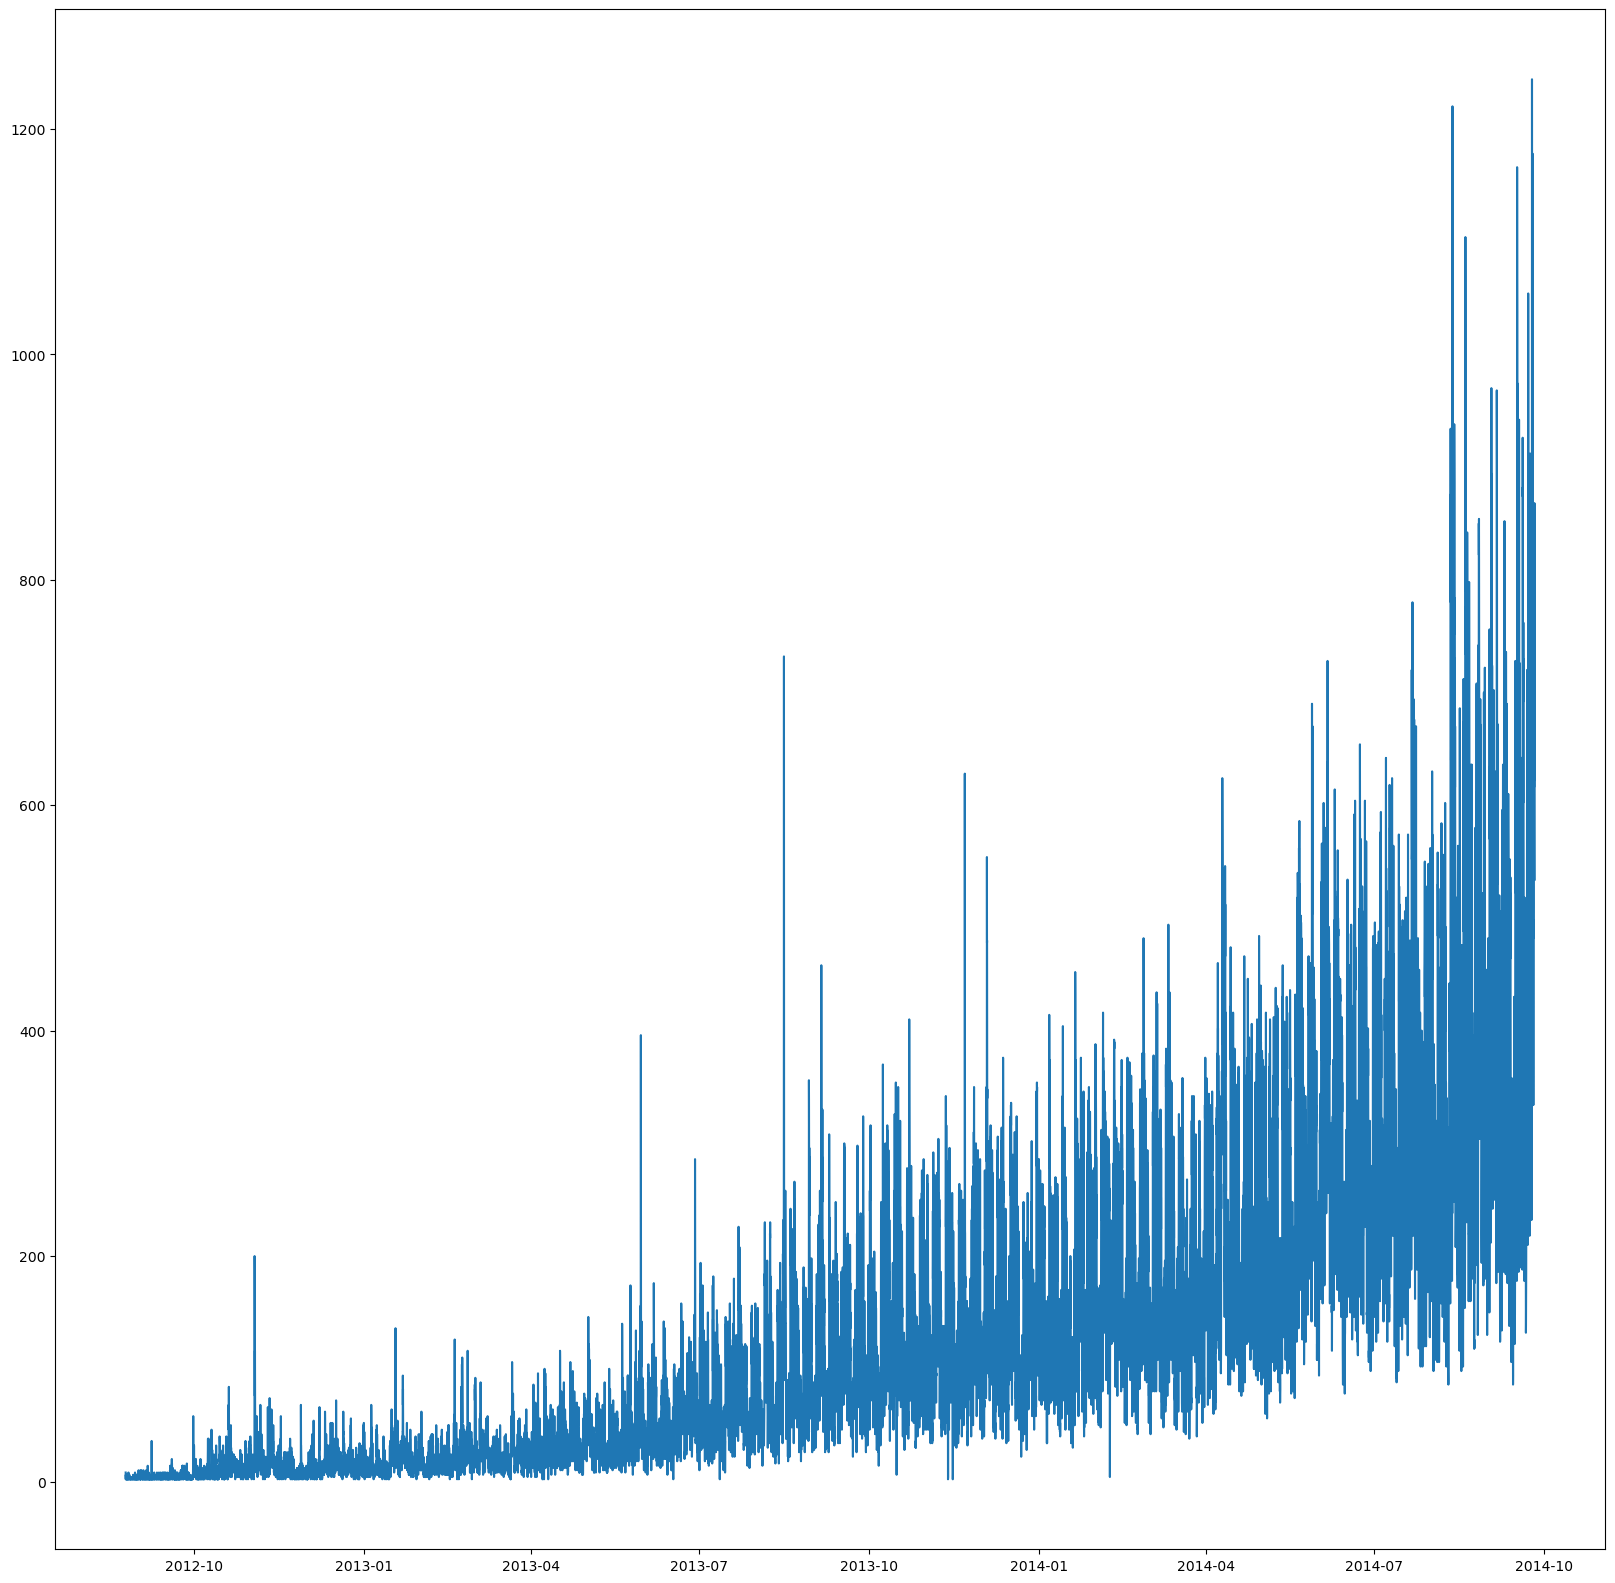

In [6]:
plt.figure(figsize=(20,20))
plt.plot(df["Datetime"],df["Count"])

In [7]:
df.index=df['Datetime']
df['y']=df['Count']
df.drop(columns=['Count','Datetime','ID'],axis=1,inplace=True)

In [8]:
df.head(5)

,y
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [9]:
df=df.resample('D').sum()

In [10]:
df.head(5)

,y
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [11]:
len(df)

762

In [12]:
df.reset_index(inplace=True)

In [13]:
df.rename(columns={'Datetime':'ds','y':'y'},inplace=True)

In [14]:
df.shape

(762, 2)

In [15]:
df.head(5)

,ds,y
0,2012-08-25,76
1,2012-08-26,88
2,2012-08-27,62
3,2012-08-28,58
4,2012-08-29,60


In [16]:
result=adfuller(df["y"])

In [17]:
print(result)

(2.986350959013848, 1.0, 20, 741, {'1%': -3.4392057325732104, '5%': -2.8654483492874236, '10%': -2.5688512291811225}, 11921.943836159979)


In [18]:
print(result[1])

1.0


In [77]:
df["y"]=df["y"].diff().diff()

In [79]:
df=df[2:]

In [80]:
result2=adfuller(df["y"])

In [82]:
print(result2[1])

1.9359869122296478e-23


The given data in non-stationary and hence we need to apply differencing to make it stationary.
FBProphet can hande data that is not-stationary,unlike other models.

# Implementing LSTM

In [19]:
df2=df[:750]

In [21]:
df2.head(5)

,ds,y
0,2012-08-25,76
1,2012-08-26,88
2,2012-08-27,62
3,2012-08-28,58
4,2012-08-29,60


In [22]:
df2.drop("ds",axis=1,inplace=True)

C:\Users\Hi\AppData\Local\Temp\ipykernel_7300\1533910961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop("ds",axis=1,inplace=True)


In [23]:
df2

,y
0,76
1,88
2,62
3,58
4,60
...,...
745,13104
746,11592
747,10180
748,9010


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [25]:
length=25
n_features=1

In [26]:
model=Sequential()
model.add(LSTM(25,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))

C:\Users\Hi\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.compile(optimizer="adam",loss="mse")

In [28]:
df2.head()

,y
0,76
1,88
2,62
3,58
4,60


In [29]:
df2['y']=df2['y'].diff().diff()

C:\Users\Hi\AppData\Local\Temp\ipykernel_7300\1833530904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y']=df2['y'].diff().diff()


In [30]:
df2['y']

0         NaN
1         NaN
2       -38.0
3        22.0
4         6.0
        ...  
745    -468.0
746   -4392.0
747     100.0
748     242.0
749   -1760.0
Name: y, Length: 750, dtype: float64

In [31]:
scaled_train=df2[2:725]

In [32]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [33]:
scaled_train=np.asarray(scaled_train)

In [34]:
scaled_train.shape

(723, 1)

In [35]:
scaled_train=scaled_train.reshape(-1,1)

In [36]:
batch_size=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

In [37]:
model.fit(generator,epochs=5)

Epoch 1/5
 23/698 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2362739.2500 

C:\Users\Hi\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2451298.7500
Epoch 2/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2844580.0000
Epoch 3/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2906421.5000
Epoch 4/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2204260.5000
Epoch 5/5
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2186195.0000


In [38]:
generator[0]

(array([[[ -38.],
         [  22.],
         [   6.],
         [  12.],
         [ -10.],
         [  30.],
         [ -28.],
         [ -16.],
         [ -32.],
         [  80.],
         [ -42.],
         [ -28.],
         [  64.],
         [ -64.],
         [  28.],
         [  -2.],
         [  32.],
         [ -38.],
         [  24.],
         [  -4.],
         [ -30.],
         [  44.],
         [  74.],
         [-126.],
         [ -44.]]]),
 array([[80.]]))

In [39]:
df2.iloc[25]

y   -126.0
Name: 25, dtype: float64

# Time Series Generator has generated the same value

# evaluation

In [40]:
first_eval_batch=scaled_train[-length:]

In [41]:
first_eval_batch

array([[  334.],
       [  162.],
       [ 2920.],
       [-2780.],
       [  608.],
       [  -38.],
       [  204.],
       [-3354.],
       [ 1970.],
       [ 4470.],
       [-4680.],
       [ 2594.],
       [-2580.],
       [ 1504.],
       [-3314.],
       [ 3304.],
       [ 6746.],
       [-5272.],
       [-1718.],
       [-5322.],
       [ 3966.],
       [  432.],
       [  -66.],
       [ 4036.],
       [   30.]])

In [42]:
np.shape(first_eval_batch)

(25, 1)

In [43]:
first_eval_batch=first_eval_batch.reshape((1,length,n_features))

In [44]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


array([[-46.91975]], dtype=float32)

In [45]:
df2.iloc[725]

y   -4274.0
Name: 725, dtype: float64

In [46]:
results=[]
i=25
sliding_set=df2.iloc[701:726]
while i!=0:    
    sliding_set=np.asarray(sliding_set)
    sliding_set=sliding_set.reshape((1,length,n_features))
    ans=model.predict(sliding_set)
    print(ans)
    results.append(ans.tolist()[0][0])
    sliding_set=sliding_set.reshape(-1)
    sliding_set=sliding_set.tolist()
    sliding_set.pop(0)
    sliding_set.append(ans.tolist()[0][0])
    i-=1
    

 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[1087.0985]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[6.617241]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[695.27875]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-7.5854735]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[450.64893]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-52.515297]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[543.99493]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-132.24524]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-56.024918]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[671.87823]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[-84.55373]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[2245.2144]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-744.9022]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[465.03152]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[229.44952]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[-276.4866]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[-1565.2877]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[385.13327]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[322.48505]]
1/1 ━━━━

In [47]:
results_df=pd.DataFrame(results)

In [48]:
results_df

,0
0,1087.098511
1,6.617241
2,695.278748
3,-7.585474
4,450.648926
5,-52.515297
6,543.994934
7,-132.245239
8,-56.024918
9,671.878235


In [49]:
results_df.head(5)

,0
0,1087.098511
1,6.617241
2,695.278748
3,-7.585474
4,450.648926


In [63]:
results_df.columns=["lstm"]

<AxesSubplot:>

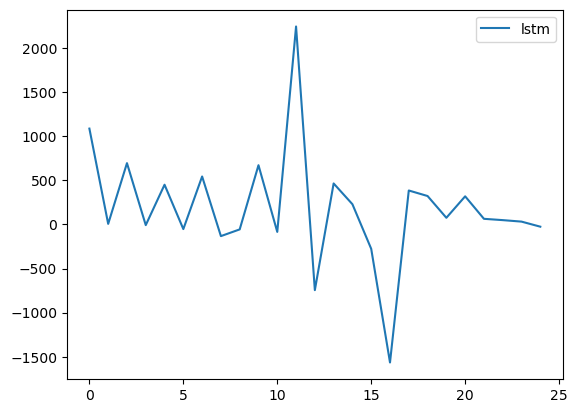

In [64]:
results_df.plot(kind="line")

In [65]:
actual_df=df2[726:751]

In [66]:
type(actual_df)

pandas.core.frame.DataFrame

In [67]:
type(results_df)

pandas.core.frame.DataFrame

In [68]:
actual_df.reset_index(inplace=True)

In [69]:
actual_df.drop("index",axis=1,inplace=True)

C:\Users\Hi\AppData\Local\Temp\ipykernel_7300\3951513225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_df.drop("index",axis=1,inplace=True)


In [75]:
actual_df.columns=["actual"]

<AxesSubplot:>

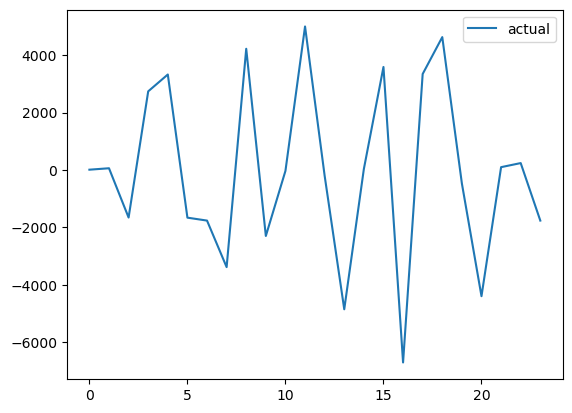

In [76]:
actual_df.plot(kind="line")

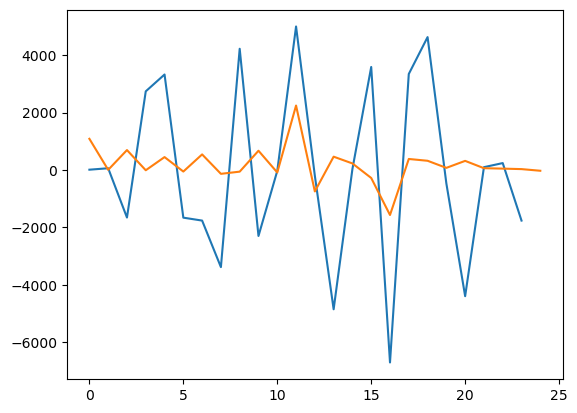

In [83]:
plt.plot(actual_df["actual"])
plt.plot(results_df["lstm"])


In [1]:
from sklearn.metrics import mean_squared_error

C:\Users\Hi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("The mean squared error is ",mean_squared_error(actual_df["actual"],results_df["lstm"][:-1]))

NameError: name 'actual_df' is not defined